In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from custom_transformers import LogTransformer
import os
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [2]:
os.makedirs('./output_csv', exist_ok=True)
df = pd.read_csv("../build_dataset/output_csv/bloomberg_data.csv")
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Offer Size (M),Sales - 1 Yr Growth,Profit Margin,Return on Assets,Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Filing Term Price Range,Priced Range,Industry Group,Industry Sector,Industry Subgroup,Instit Owner (% Shares Out),Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,AWE US,New Cingular Wireless Services Inc,10620.00,NaN,NaN,0.075987,360.0,29.5,7.838983,10620.0,...,26.00 - 32.00,Priced Within Range,Telecommunications,Communications,Cellular Telecom,0.000341,6.019667,180.3,109.2,3.8
1,3527578Q US,Agere Systems Inc,4140.00,-6.3,1.2,3.300000,600.0,6.0,0.333333,3600.0,...,6.00 - 7.00,Priced Within Range,Semiconductors,Technology,Electronic Compo-Semicon,NaN,5.310968,184.7,91.5,4.3
2,BGPTQ US,BearingPoint Inc,2328.38,-7.4,-1.0,-1.700000,0.0,18.0,30.468750,0.0,...,16.00 - 18.00,Priced Within Range,Commercial Services,"Consumer, Non-cyclical",Consulting Services,0.009101,5.494286,184.4,90.6,4.2


In [3]:
def convert_features(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for
    month, day, and year, and drop the original 'Trade Date (US)' column.

    Also, convert Offer To 1st Close to a binary classification (Underpriced
    column) and drop original column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df['Underpriced'] = df['Offer To 1st Close'].apply(lambda x: 1 if x < 0 else 0)  

    df = df.sort_values('Trade Date (US)')
    df['Prev_5_IPOs_Underpriced'] = df['Underpriced'].shift(1).rolling(window=5, min_periods=1).mean()
    df['Prev_5_IPOs_Underpriced'] = df['Prev_5_IPOs_Underpriced'].apply(lambda x: 1 if x >= 0.6 else 0)
    df.drop(columns=['Trade Date (US)'], inplace=True)
    df.drop(columns=['Offer To 1st Close'], inplace=True)
    return df


df_convert_features = convert_features(df)

In [4]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_features)

In [5]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets, using stratified sampling, 
    and encode the features.
    """

    X = df.drop(columns=['Underpriced'])
    y = df['Underpriced']

    assert y.isnull().sum() == 0, "Target variable contains missing values"
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, shuffle=True, stratify=y_dev)

    # FILL MISSING VALUES
    for col in X_train.columns:
        if col in ['Trade Month', 'Trade Day', 'Trade Year']:
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
            X_val[col] = X_val[col].fillna(X_train[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_train[col].mode()[0])
        elif X_train[col].dtype == 'object' and col not in ['Trade Month', 'Trade Day', 'Trade Year']:
            X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
            X_val[col] = X_val[col].fillna(X_train[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_train[col].mode()[0])
        else:
            X_train[col] = X_train[col].fillna(X_train[col].mean())
            X_val[col] = X_val[col].fillna(X_train[col].mean())
            X_test[col] = X_test[col].fillna(X_test[col].mean())


    # ENCODING FEATURES
    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year']
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    log_columns = ['Offer Price', 'Market Cap at Offer (M)']
    exclude_columns = oe_columns + log_columns + ohe_columns
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in exclude_columns]

    oe = OrdinalEncoder()
    log = LogTransformer()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('log', log, log_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_train = preprocess.fit_transform(X_train)
    transformed_val = preprocess.transform(X_val)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_train = pd.DataFrame(transformed_train, columns=features).reset_index(drop=True)
    df_val = pd.DataFrame(transformed_val, columns=features).reset_index(drop=True)
    df_test = pd.DataFrame(transformed_test, columns=features).reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    df_train = pd.concat([df_train, y_train], axis=1)
    df_val = pd.concat([df_val, y_val], axis=1)
    df_test = pd.concat([df_test, y_test], axis=1)

    return df_train, df_val, df_test, preprocess


df_train_encoded, df_val_encoded, df_test_encoded, preprocess = encoding(df_drop_columns)

In [6]:
def show_feature_importances(df):
    """
    Calculate feature importance using a simple model
    """
    X_train = df.drop(columns=['Underpriced'])
    y_train = df['Underpriced']
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importances(df_train_encoded)


Feature Importances:
ss__Offer Size (M)                 0.058271
ss__Shares Outstanding (M)         0.053460
log__Market Cap at Offer (M)       0.051315
ss__Cash Flow per Share            0.049750
ss__CPI                            0.049105
oe__Trade Day                      0.048474
ss__Return on Assets               0.048401
ss__Consumer Confidence            0.046245
ss__Fed Rate                       0.045445
ss__Instit Owner (% Shares Out)    0.043998
dtype: float64


In [7]:
def get_correlation(df_train, df_val, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_train = df_train.drop(columns=['Underpriced'])
    y_train = df_train['Underpriced']

    X_val = df_val.drop(columns=['Underpriced'])
    y_val = df_val['Underpriced']

    X_test = df_test.drop(columns=['Underpriced'])
    y_test = df_test['Underpriced']

    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced_train = X_train.drop(columns=to_drop)
    X_reduced_val = X_val.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_train = pd.concat([X_reduced_train, y_train.reset_index(drop=True)], axis=1)
    df_val = pd.concat([X_reduced_val, y_val.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")

    df_train.to_csv('./output_csv/Final_Output_Class_train.csv', index=False)
    df_val.to_csv('./output_csv/Final_Output_Class_val.csv', index=False)
    df_test.to_csv('./output_csv/Final_Output_Class_test.csv', index=False)

    return df_train, df_val, df_test

df_train_correlation, df_val_correlation, df_test_correlation = get_correlation(df_train_encoded, df_val_encoded, df_test_encoded)


Removed 30 correlated features.


Underpriced
0    2407
1     613
Name: count, dtype: int64

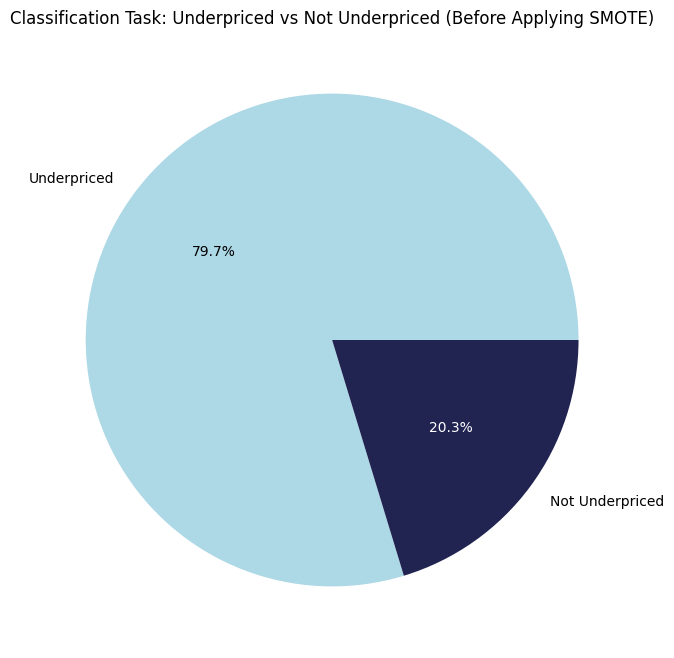

In [8]:
def display_distribution(df_train_correlation):
    """
    Displaying pie plot to show target data imbalance.
    """
    df = df_train_correlation.copy()
    plt.figure(figsize=(8, 8))
    underpriced_counts = df['Underpriced'].value_counts()
    display(underpriced_counts)
    labels = ['Underpriced', 'Not Underpriced']
    colors = ['lightblue', '#212351']

    _, _, autotexts = plt.pie(
        underpriced_counts, labels=labels, colors=colors,
        autopct='%1.1f%%', textprops={'color': 'black'}
    )

    for i, autotext in enumerate(autotexts):
        if colors[i] == '#212351':
            autotext.set_color('white')

    plt.title('Classification Task: Underpriced vs Not Underpriced (Before Applying SMOTE)')
    plt.show()
    
display_distribution(df_train_correlation)

In [9]:
def checkimbalance(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_train = df.drop(columns=['Underpriced'])
    y_train = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()

    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")

    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_train.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df
    
df_train_resampled = checkimbalance(df_train_correlation, './output_csv/Final_Output_Class_train.csv')

Class distribution (normalized):
Underpriced
0    0.79702
1    0.20298
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    2407
1     613
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 3020 rows
The resampled dataset has 4814 rows
Resampled feature matrix shape: (4814, 375)


In [10]:
def checkimbalance_undersampling(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using Undersamping.
    """
    X_train = df.drop(columns=['Underpriced'])
    y_train = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying UnderSampling...')
        sampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        df_final = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns),
                              pd.Series(y_resampled, name='Underpriced')], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_train.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df

df_train_resampled_under = checkimbalance_undersampling(df_train_correlation, './output_csv/Final_Output_Class_train_under.csv')


Class distribution (normalized):
Underpriced
0    0.79702
1    0.20298
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    2407
1     613
Name: count, dtype: int64

The data is imbalanced. Applying UnderSampling...
The initial dataset had 3020 rows
The resampled dataset has 1379 rows
Resampled feature matrix shape: (1379, 375)


In [11]:
def smote_tomek(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_train = df.drop(columns=['Underpriced'])
    y_train = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTETomek(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_train.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df
    
df_train_resampled_tomek = smote_tomek(df_train_correlation, './output_csv/Final_Output_Class_train_tomek.csv')

Class distribution (normalized):
Underpriced
0    0.79702
1    0.20298
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    2407
1     613
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 3020 rows
The resampled dataset has 4766 rows
Resampled feature matrix shape: (4766, 375)


### Model Training

In [12]:
def get_enhanced_model_params():
    """
    Return enhanced classification models with wider search space
    """
    return {
        "Dummy Classifier": {
            "model": DummyClassifier(strategy='most_frequent'),
            "params": {}
        },
        "Logistic Regression": {
            "model": LogisticRegression(solver='lbfgs', random_state=42, max_iter=10000, tol=1e-3),
            "params": {
                "C": [0.01, 0.1, 1, 10, 100],
                "penalty": ['l1', 'l2']
            }
        },
        "Ridge Classifier": {
            "model": RidgeClassifier(max_iter=10000, tol=1e-3),
            "params": {
                "alpha": [0.1, 1.0, 10.0]
            }
        },
        "Random Forest Classifier": {
            "model": RandomForestClassifier(random_state=42, n_jobs=-1),
            "params": {
                'n_estimators': [100, 200],
                'max_depth': [10, 15],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [3, 5],
                'max_features': ['sqrt'],
                'bootstrap': [True],
                'criterion': ['gini']
            }
        },
        "K-Nearest Neighbors": {
            "model": KNeighborsClassifier(),
            "params": {
                "n_neighbors": [3, 5, 7],
                "weights": ["uniform", "distance"]
            }
        },
        "Gaussian Naive Bayes": {
            "model": GaussianNB(),
            "params": {
                "var_smoothing": [1e-9, 1e-8, 1e-7]
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(random_state=42),
            "params": {
                "max_depth": [None, 5, 10, 15],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        },
        "Shallow MLP": {
            "model": MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
            "params": {
                "hidden_layer_sizes": [(50,), (100,)],
                "alpha": [0.0001, 0.001],
                "activation": ["relu", "tanh"]
            }
        },
        "LightGBM": {
            "model": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
            "params": {
                "n_estimators": [100, 200],
                "learning_rate": [0.01, 0.1],
                "max_depth": [3, 5, 7],
                "num_leaves": [31, 63]
            }
        },
        "SGD Classifier": {
            "model": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
            "params": {
                "alpha": [0.0001, 0.001, 0.01],
                "loss": ["hinge", "log_loss"],
                "penalty": ["l2", "l1", "elasticnet"]
            }
        }
    }

In [13]:
def evaluate_models(model_params, X_train, y_train, X_val, y_val):
    """Evaluate classification models with multiple metrics"""
    results = []

    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"],
                    mp["params"],
                    cv=skf,
                    scoring='f1',
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
            else:
                best_model = mp["model"]
                best_model.fit(X_train, y_train)
                print("✓ (No tuning needed)")

            cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1')

            y_pred = best_model.predict(X_val)

            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)

            results.append({
                "Model": name,
                "Accuracy": acc,
                "F1 Score": f1,
                "Precision": precision,
                "Recall": recall,
                "CV F1 Mean": cv_scores.mean(),
                "CV F1 Std": cv_scores.std()
            })

            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_train, y_train, cv=skf, scoring='f1',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
            plt.fill_between(train_sizes,
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    top5_models_df = results_df.sort_values(by="F1 Score", ascending=False).head(5).reset_index(drop=True)

    return results_df, top5_models_df

In [14]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [15]:
def evaluate_best_model(model_params, X_dev, y_dev, X_test, y_test, top5_models_df):
    """
    Evaluate the best model on the test set
    """
    best_model_name = top5_models_df.iloc[0]['Model']
    best_model = model_params[best_model_name]['model']
    best_model.fit(X_dev, y_dev)

    dummy_model = model_params['Dummy Classifier']['model']
    dummy_model.fit(X_dev, y_dev)

    y_pred = best_model.predict(X_test)
    y_pred_dummy = dummy_model.predict(X_test)


    test_metrics = {
        "Model": best_model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "Dummy F1 Score": f1_score(y_test, y_pred_dummy, zero_division=0)
    }

    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv('./output_csv/best_model_Class_test_results.csv', index=False)

    print("\nTest Set Performance:")
    display(metrics_df)

In [16]:
def main():
    try:
        df_train = pd.read_csv('./output_csv/Final_Output_Class_train_tomek.csv')
        df_val = pd.read_csv('./output_csv/Final_Output_Class_val.csv')
        df_test = pd.read_csv('./output_csv/Final_Output_Class_test.csv')
        
        X_train = clean_column_names(df_train.drop(columns=['Underpriced']))
        y_train = df_train['Underpriced']

        X_val = clean_column_names(df_val.drop(columns=['Underpriced']))
        y_val = df_val['Underpriced']

        X_test = clean_column_names(df_test.drop(columns=['Underpriced']))
        y_test = df_test['Underpriced']

        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_train, y_train, X_val, y_val)

        print("\nTop 5 Models:")
        display(top5_models_df)

        results_df.to_csv('./output_csv/classification_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_classification_models.csv', index=False)

        X_dev = pd.concat([X_train, X_val])
        y_dev = pd.concat([y_train, y_val])

        evaluate_best_model(model_params, X_dev, y_dev, X_test, y_test, top5_models_df)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Evaluating 10 models...

[1/10] Training and evaluating: Dummy Classifier... ✓ (No tuning needed)


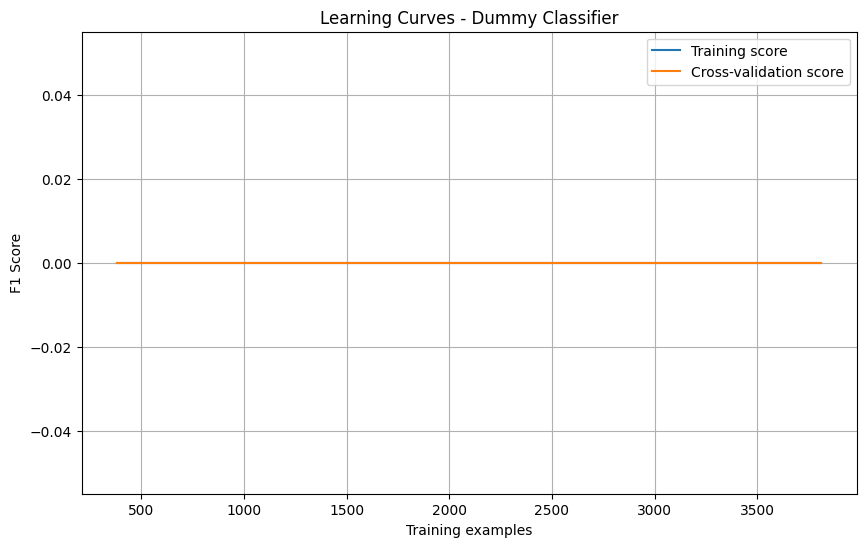

[2/10] Training and evaluating: Logistic Regression... ✓ (GridSearch complete)


In [ ]:
main()